<a href="https://colab.research.google.com/github/xementor/c/blob/main/Bangla_NLP_Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downlaod Dataset and Library

In [1]:
!gdown --fuzzy "https://drive.google.com/file/d/112hpGzc1Y0sxoD-Q3B-jW1Je9n_m5-l8/view?usp=share_link"
!gdown --fuzzy "https://drive.google.com/file/d/1LZdCAMq2qh27qEOz5AM2PuuxE62O_UFi/view?usp=share_link"

Downloading...
From: https://drive.google.com/uc?id=112hpGzc1Y0sxoD-Q3B-jW1Je9n_m5-l8
To: /content/Train.csv
100% 3.65M/3.65M [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LZdCAMq2qh27qEOz5AM2PuuxE62O_UFi
To: /content/TiroBangla-Regular.ttf
100% 288k/288k [00:00<00:00, 134MB/s]


In [2]:
!pip install -q python-Levenshtein scikit-plot bnlp_toolkit git+https://github.com/biplobsd/Bangla-stemmer.git git+https://github.com/biplobsd/number-to-bengali-word.git git+https://github.com/banglakit/lemmatizer.git#egg=banglakit-lemmatizer

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [3]:
!pip install -q bangla-stemmer

## Imprting Libaray

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

## Dataset Exploration

In [5]:
df = pd.read_csv("/content/Train.csv")

In [6]:
df.head()

,ID,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Topic,Domain,is_admin
0,5454,লকাল বাস ভালো এটা থেকে,0,0,0,0,1,0,Travel,Youtube,False
1,22549,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0,0,1,0,Politics,Youtube,False
2,7033,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0,1,0,0,Personal,Facebook,False
3,21114,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0,0,1,0,Education,Facebook,False
4,23683,সত্যিকার মানুষ তারাই ভাই,0,1,0,0,0,0,Personal,Youtube,False


In [7]:
df.shape


(18420, 11)

In [8]:

df['Result'] = df.apply(lambda row: 0 if row['Love'] == 1 else
                                    1 if row['Joy'] == 1 else
                                    2 if row['Surprise'] == 1 else
                                    3 if row['Anger'] == 1 else
                                    4 if row['Sadness'] == 1 else
                                    5 if row['Fear'] == 1 else None, axis=1)


In [9]:
data = df.Data

## Tokenizing, Stop Word Removing

In [10]:
import inflect
from bnlp import NLTKTokenizer
from banglakit import lemmatizer as lem
from banglakit.lemmatizer import BengaliLemmatizer
# from bangla_stemmer.stemmer import stemmer
from bnlp.corpus import stopwords, punctuations
from number_to_bengali.main import to_bn_word

lemmatizer = BengaliLemmatizer()
bnltk = NLTKTokenizer()
# stmr = stemmer.BanglaStemmer(log_print=False)
punctuationsExtened = punctuations+'‘’“”'

def norm_url(text):  
  return re.sub(r'http\S+|www.\S+|pic.\S+', '',text.lower())

def norm_email(text):  
  return re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '',text)

def norm_tag(text):  
  return re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', '',text)

def remove_phone_numbers(text):
  return re.sub(r'(01|০১|০৯)\d{9}', '', text)

def process_text(text):
  token_words = bnltk.word_tokenize(text)
  return token_words

def remove_punctuation(words):
  """Remove punctuation from list of tokenized words"""
  new_words = []
  for word in words:
      if not word in punctuationsExtened:
        new_words.append(word)
  return new_words

def replace_numbers(words):
  """Replace all interger occurrences in list of tokenized words with textual representation"""
  new_words = []
  for word in words:
      if word.isdigit():
          try:
            new_word = to_bn_word(word)
          except KeyError:
            print(word)
            raise Exception('Error:', word)
          new_words.append(new_word)
      else:
          new_words.append(word)
  return new_words


def remove_numbers(words):
    """Replace all integer occurrences in a list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if not word.isdigit():
            new_words.append(word)
    return new_words

def remove_stopwords(words):
  """Remove stop words from list of tokenized words"""
  new_words = []
  for word in words:
      if word not in stopwords:
          new_words.append(word)
  return new_words

def stem_words(words):
  """Stem words in list of tokenized words"""
  stems = []
  for word in words:
      stem = stmr.stem(word)
      stems.append(stem)
  return stems

def lemmatize_verbs(words):
  """Lemmatize verbs in list of tokenized words"""
  lemmas = []
  for word in words:
      lemma = lemmatizer.lemmatize(word, pos=lem.POS_PROPN)
      lemmas.append(lemma)
  return lemmas

def normalize(text):
  text = norm_url(text)
  text = norm_email(text)
  text = norm_tag(text)
  text = remove_phone_numbers(text)
  words = process_text(text)
  words = remove_punctuation(words)
  words = remove_numbers(words)
  words = remove_stopwords(words)
  # words = stem_words(words)
  words = lemmatize_verbs(words)
  return words

def normalize_to_string(text):
  return ' '.join(normalize(text))

In [11]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    df[col_name] = df[col_name].progress_apply(normalize_to_string)
    return df

<ipython-input-11-15a3eb9c005a>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [12]:
cleaned_df = text_preprocessing(df.copy(), "Data")

  0%|          | 0/18420 [00:00<?, ?it/s]

In [13]:
cleaned_df.Data.head()

0                                        লকাল বাস ভালো
1                          অভিজানই ওয়াসার পানির অভিজান
2    বিয়ের মহল ছেড়ে বিস্রাম নং ছবি বিয়ের মারা নব...
3                               চাচাজি কেবল মাকে ধর্ষণ
4                             সত্যিকার মানুষ তারাই ভাই
Name: Data, dtype: object

In [14]:
df.Data.head()

0                              লকাল বাস ভালো এটা থেকে 
1    কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...
2    বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...
3                    চাচাজি তো কেবল মাকে ধর্ষণ করেছেন 
4                            সত্যিকার মানুষ তারাই ভাই 
Name: Data, dtype: object

In [15]:
### Calculating the word frequency by using nltk
import nltk
words_list = []
for sentence in cleaned_df.Data:
    words_list.extend(bnltk.word_tokenize(sentence))
freq_dist = nltk.FreqDist(words_list)
freq_dist.most_common(20)

[('ভাই', 2565),
 ('ভালো', 1848),
 ('-PRON-', 1168),
 ('একটা', 1030),
 ('লাগ', 966),
 ('দেখ', 736),
 ('টা', 734),
 ('ভিডিও', 704),
 ('যাওয়া', 671),
 ('কথা', 670),
 ('গান', 669),
 ('নাটক', 645),
 ('সাথে', 645),
 ('মানুষ', 608),
 ('সুন্দর', 597),
 ('কর', 597),
 ('ধন্যবাদ', 579),
 ('ভাল', 538),
 ('চাই', 528),
 ('বল', 504)]

<Figure size 640x480 with 0 Axes>

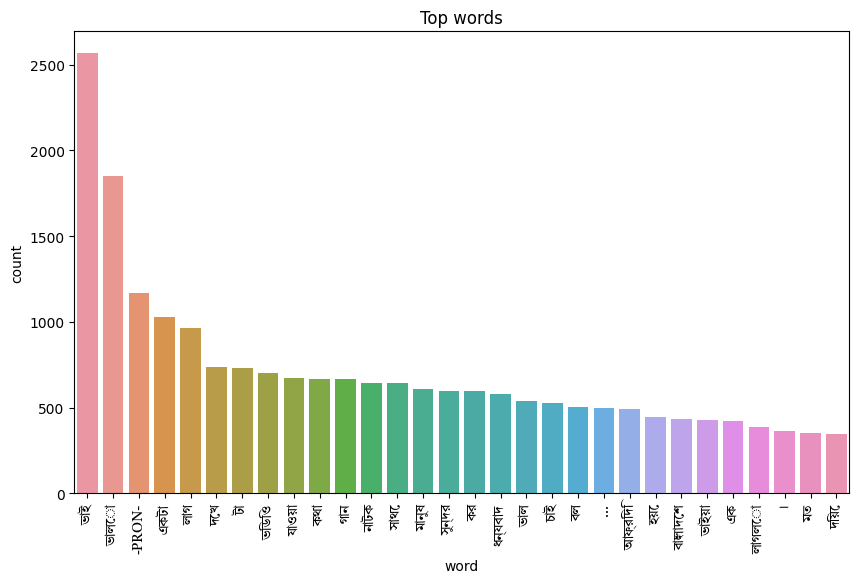

In [16]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

plt.figure() 
prop = FontProperties()
prop.set_file('/content/TiroBangla-Regular.ttf')
temp = pd.DataFrame(freq_dist.most_common(30),  columns=['word', 'count'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=temp, ax=ax)
plt.title("Top words")
plt.xticks(rotation='vertical', fontproperties=prop)
plt.show()

## BOW (Bag of word)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


documents = cleaned_df.Data.values
labels = df.Result.values

# Step 2: Create vocabulary using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)
vocabulary = vectorizer.get_feature_names_out()

# Step 3: Represent documents using BoW vectors
bow_representation = X.toarray()

# # Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bow_representation, labels, test_size=0.2, random_state=42)

# # Step 5: Train the Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# # Step 6: Predict the class labels for the testing set
predictions = classifier.predict(X_test)

# # Step 7: Measure the classification accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.46715526601520085


## Embedding

In [17]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
df.shape

(18420, 12)

In [19]:
vocab_size = 7000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 15000


In [20]:
sentences = cleaned_df.Data.values
labels = df.Result.values

In [21]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [22]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [23]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.summary()


In [28]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
469/469 - 3s - loss: 1.5705 - accuracy: 0.3335 - val_loss: 1.4899 - val_accuracy: 0.3556 - 3s/epoch - 6ms/step
Epoch 2/30
469/469 - 2s - loss: 1.4967 - accuracy: 0.3508 - val_loss: 1.4793 - val_accuracy: 0.3561 - 2s/epoch - 4ms/step
Epoch 3/30
469/469 - 2s - loss: 1.4780 - accuracy: 0.3565 - val_loss: 1.4540 - val_accuracy: 0.3614 - 2s/epoch - 4ms/step
Epoch 4/30
469/469 - 2s - loss: 1.4371 - accuracy: 0.3831 - val_loss: 1.4013 - val_accuracy: 0.3854 - 2s/epoch - 4ms/step
Epoch 5/30
469/469 - 2s - loss: 1.3704 - accuracy: 0.4182 - val_loss: 1.3440 - val_accuracy: 0.4336 - 2s/epoch - 4ms/step
Epoch 6/30
469/469 - 3s - loss: 1.2893 - accuracy: 0.4627 - val_loss: 1.2695 - val_accuracy: 0.4477 - 3s/epoch - 5ms/step
Epoch 7/30
469/469 - 2s - loss: 1.2163 - accuracy: 0.4907 - val_loss: 1.2247 - val_accuracy: 0.4795 - 2s/epoch - 4ms/step
Epoch 8/30
469/469 - 2s - loss: 1.1632 - accuracy: 0.5083 - val_loss: 1.1960 - val_accuracy: 0.4851 - 2s/epoch - 3ms/step
Epoch 9/30
469/469 - 2s 

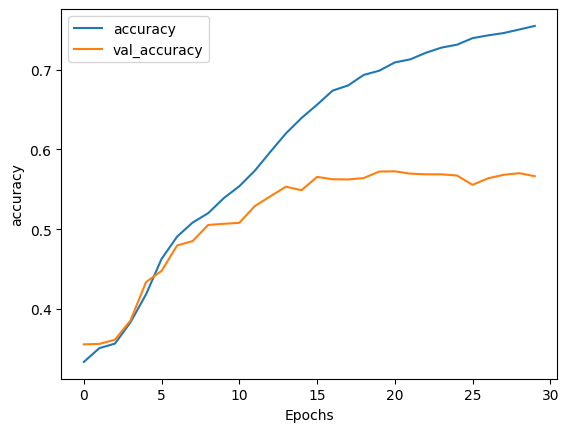

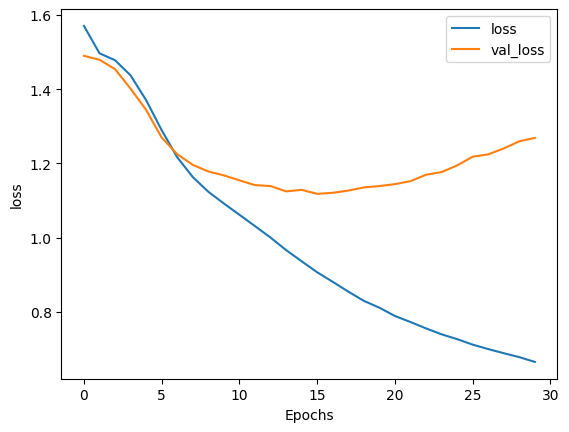

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [30]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

<OOV> বাস ভালো ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
বিয়ের মহল ছেড়ে বিস্রাম নং ছবি বিয়ের মারা নব বধু
3


In [34]:
df.Data.values[:6]

array(['লকাল বাস ভালো এটা থেকে ',
       'কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান করে না কেন ',
       'বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ নং ছবি )বিয়ের ৫ দিন পর মারা যান এই নব বধু ',
       'চাচাজি তো কেবল মাকে ধর্ষণ করেছেন ', 'সত্যিকার মানুষ তারাই ভাই ',
       'ভালবাসা আরো হাগার গুণ বেড়ে গেল '], dtype=object)

In [38]:
sentence = ["সাকিব খেলায় ১০০ করেছে", "দূর হ শালা", "শালা আমার অনেক ভালো", "বিয়ে করে ফেসে গেলাম"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 25ms/step
[[1.0144266e-01 6.5052831e-01 5.9717711e-02 1.0694025e-01 7.1272954e-02
  1.0098132e-02]
 [2.3330199e-06 7.0012704e-04 1.1017858e-03 3.8735364e-03 9.9426728e-01
  5.4991971e-05]
 [4.5733268e-06 1.6731655e-03 1.2962394e-03 3.6043189e-03 9.9335915e-01
  6.2562423e-05]
 [5.2610043e-02 4.7345021e-01 7.9321623e-02 1.7125762e-01 2.1159090e-01
  1.1769616e-02]]
